# Lab 5: Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.

You have to send the filled notebook named **"NMF_familyname1_familyname2.ipynb"** (groups of 2) by email to *aml.centralesupelec.2020@gmail.com* a week from now and put **"NMF Lab"** in the subject. 

All questions will be graded unless it is explicitely indicated.

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import check_random_state

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## NMF

Loss (Regularized Froebnius): $\mathcal{L}(D, S) = \frac{1}{2}\|X-D S\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|S\|_{F}^{2}+\lambda\|S\|_{1}+\frac{\nu}{2}\|D\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999]: 
$
\begin{array}{c}
D \leftarrow D \circ \frac{X S^{\top}}{D (S S^{\top} + {\color{red} \nu I_r})} \\
S \leftarrow S \circ \frac{D^{\top} X - {\color{red} \lambda 1_{r \times n}}}{(D^{\top} D + {\color{red} \mu I_r})S}
\end{array}
$

Fill in the following NMF class:

In [2]:
class MYNMF():
    
    def __init__(self, n_components, random_state=42, max_iter=200):
        self.n_components_ = n_components
        self.max_iter_ = max_iter
        self.components_ = None    # shape (r, p)
        self.random_state = random_state
        self.W = None
        self.H = None
        
    def fit_transform(self, data, mu=1., lambd=1., nu=1., loss = 'frobenius', min_step = 3):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        data: (n, p) np.array
               Data matrix
        
        Returns:
        -----
        embedding: (n, r) np.array
                    Embedding matrix        
        """        
        # TODO:
        np.random.seed(self.random_state)
        # initialize both matrices
        n, p = data.shape
        r = self.n_components_

        W = np.abs(np.random.rand(p, r))
        H = np.abs(np.random.rand(r, n))
        X = data  + 1
        print(np.min(data, axis = 0).shape)
        X = X.T
        # Frobenius norm
        loss = .5*np.linalg.norm(X - np.matmul(W, H))**2 + (nu/2)*np.linalg.norm(W) + (mu/2)*np.linalg.norm(H) + lambd*np.linalg.norm(H, ord = 1)
        self.history = [loss]
        loss_prev = 0.
        i = 0

        while i <= 1 or loss_prev - loss > min_step:
            H = H*((np.matmul(W.T, X) - lambd*np.eye(W.shape[1], X.shape[1]))/np.maximum(np.matmul(np.matmul(W.T, W) + mu*np.eye(W.shape[1]), H)+ 0., 1e-6))
            W = W*(np.matmul(X, H.T)/np.maximum(np.matmul(W, np.matmul(H, H.T) + nu*np.eye(H.shape[0]) +0.), 1e-6))
            loss_prev = loss
            loss = .5*np.linalg.norm(X - np.matmul(W, H))**2 + (nu/2)*np.linalg.norm(W) + (mu/2)*np.linalg.norm(H) + lambd*np.linalg.norm(H, ord = 1)
            self.history.append(loss)
            if i%50 == 0:
                print('Epoch : ', i, ' | Loss : ', loss)
            i += 1
            
        embedding = H.T
        self.W = W
        self.H = H

        return embedding,  W, np.matmul(W, H).T
    
    
    def inverse_transform(self, embedding):
        """ Maps an embedding matrix into the original space. 
        
        Parameters:
        -----------
        embedding : (n, r) np.array
                     Embedding matrix
        
        Returns:
        -----
        data_hat : (n, p) np.array  
                   reconstructed data matrix
        """       
        data_hat = np.matmul(self.W, embedding.T).T
        
        return data_hat

    def project(self, data):
        """Project data into embedding space and get reconstruction.

        Args:
            X : (n, p) np.array
                    data to project.
        """
        X = data.T + 1
        X_hat = np.matmul(self.W, np.matmul(np.linalg.pinv(self.W), X))
        return X_hat

    def predict_label(self, data):
        """ Predict labels for X : cluster hard-assignment
        
        Parameters:
        -----------
        data: (n, p) np.array
           data matrix
        
        Returns:
        -----
        label assignment : (n, ) np.array
                          Its elements are the predicted classes, from 0 to r-1
        """
        assert self.W is not None and self.H is not None

        X = data.T + 1

        H_hat = np.matmul(np.linalg.pinv(self.W), X) #(r, n)
        norm = np.linalg.norm(self.W, axis = 0)

        # W_hat = self.W/(norm+1e-8)
        H_hat_t = H_hat.T*norm

        labels = np.argmax(H_hat_t, axis = 1)
        
        return labels
        
    def predict_proba(self, data):
        """ Predict probabilities of different classes for X :  cluster soft-assignment
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assignment : (n, r) np.array
                          Its elements are the probabilities for different classes
        """
        
        assert self.W is not None and self.H is not None

        X = data.T + 1

        H_hat = np.matmul(np.linalg.pinv(self.W), X) #(r, n)
        norm = np.linalg.norm(self.W, axis = 0)

        # W_hat = self.W/(norm+1e-8)
        proba = H_hat.T*norm
        proba = proba.T/np.sum(proba, axis = 1)

        return proba.T

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

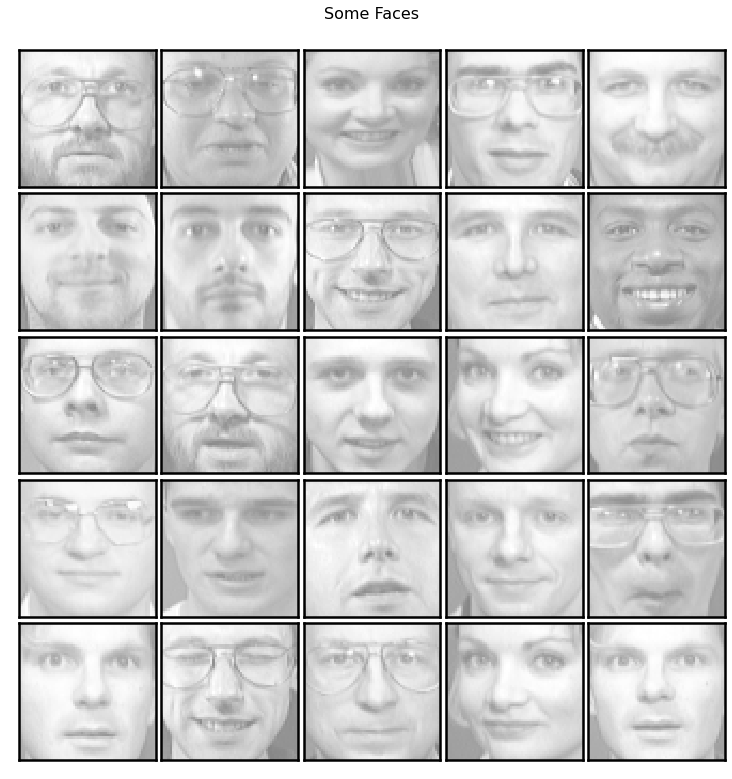

In [3]:
from sklearn.datasets import fetch_olivetti_faces


dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data  # n = 400 flattened images of p = 4096 = 64 x 64
image_shape = (64, 64)

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

def plot_gallery(images, image_shape, title='', cmap=plt.cm.gray):
    
    # fit the nb of images into a square
    n_images = len(images)
    nrows = int(np.ceil(np.sqrt(n_images)))
    ncols = nrows
    
    # instantiate figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(2. * ncols, 2.26 * nrows))
    fig.suptitle(title, size=16)
    
    axes_for_display = axes.flatten()[:n_images]
    axes_to_blank = axes.flatten()[n_images:]
    
    for idx, comp in enumerate(images):
        ax = axes_for_display[idx]
        vmax = max(comp.max(), -comp.min())
        ax.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        ax.set(xticks=(),
               yticks=())
        
    for ax in axes_to_blank:
        ax.axis('off')

    fig.tight_layout()
    fig.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)  # insert space below the suptitle
    

plot_gallery(title="Some Faces", 
             images=faces[:25], 
             image_shape=image_shape)


(4096,)
Epoch :  0  | Loss :  14635.602233167627
Epoch :  50  | Loss :  11307.191675178012
Epoch :  100  | Loss :  7648.551603342854
Epoch :  150  | Loss :  5931.24089800403
Epoch :  200  | Loss :  4946.810489995564
Epoch :  250  | Loss :  4299.969726064215
Epoch :  300  | Loss :  3864.4504481999747
Epoch :  350  | Loss :  3565.4200309362495
Epoch :  400  | Loss :  3353.2630613721435


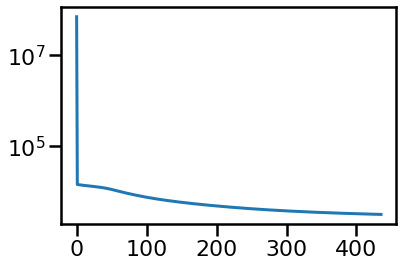

In [4]:
r = 40 # number of basis vectors

model = MYNMF(r)

mu = 0.1
lambd = 0.1
nu = 0.1

embedding, W, reconstruction = model.fit_transform(faces_centered, mu = mu, lambd = lambd, nu = nu)

plt.semilogy(model.history)

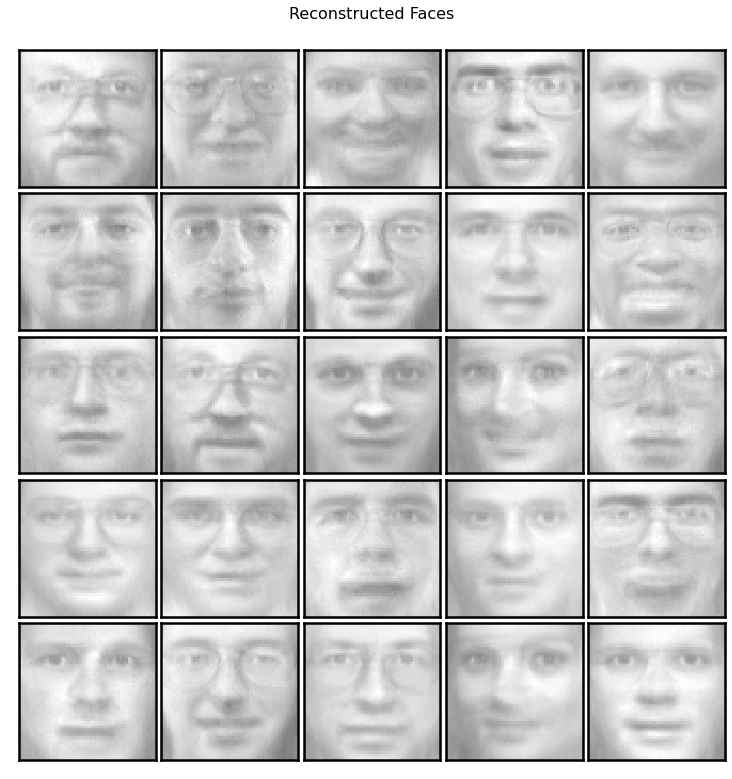

In [5]:
# Normalize reconstruction for plotting to be in the same scale.
reconstruction_n = (reconstruction - reconstruction.mean(axis = 0))/reconstruction.std(axis = 0)
reconstruction_n = reconstruction_n*faces.std(axis = 0) + faces.mean(axis = 0)

plot_gallery(title="Reconstructed Faces", 
             images=reconstruction_n[:25], 
             image_shape=image_shape)

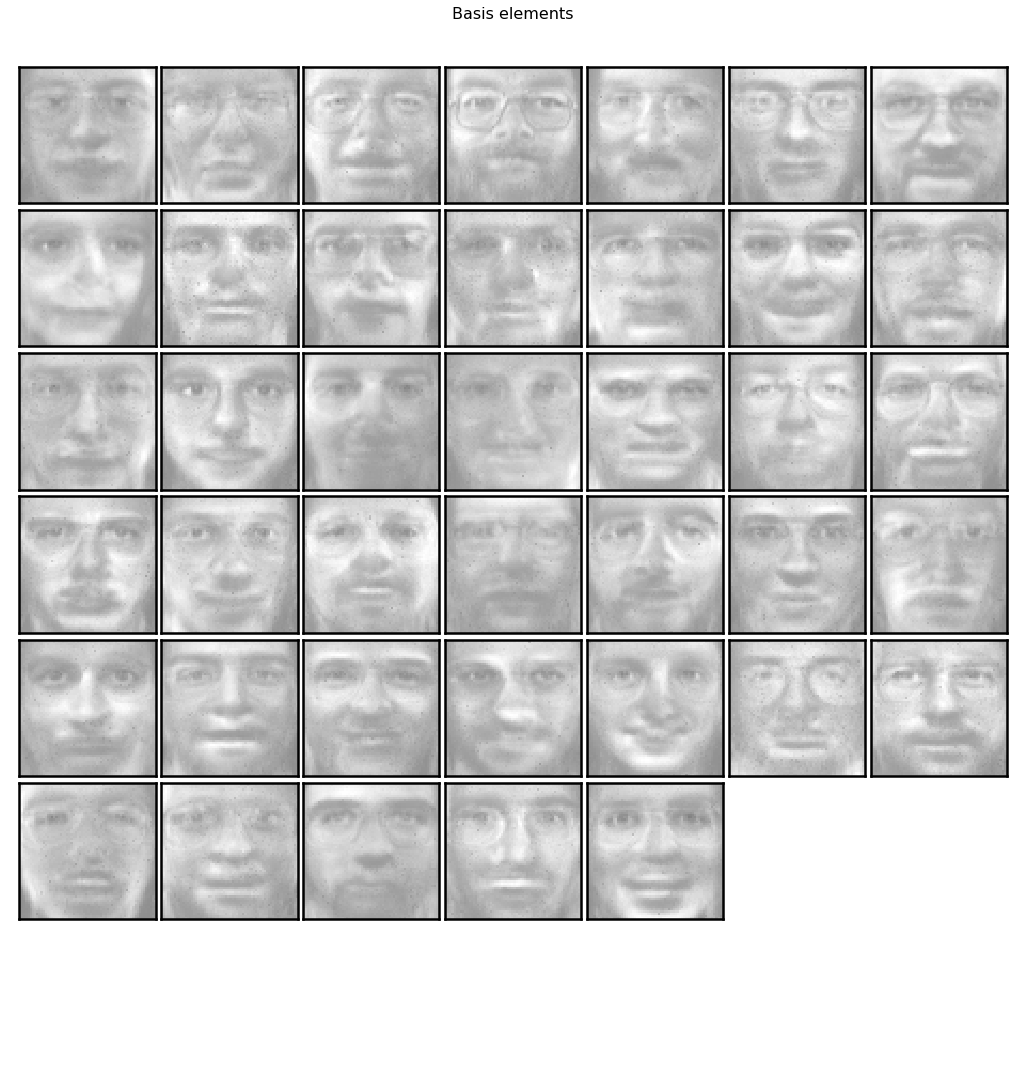

In [6]:
Wt = (W.T - W.mean(axis =1))/W.std(axis = 1)
Wt = Wt*faces.std(axis = 0) + faces.mean(axis = 0)

plot_gallery(title="Basis elements", 
             images=Wt, 
             image_shape=image_shape)

Apply *your* NMF algorithm for this dataset and plot the approximated face pictures.

- Plot the $W$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid
- Explain how to interpret both matrices W and H.
- Discuss the results you have obtained
- Conduct a critical analysis of your choice. Concretely, choose an aspect or two of the NMF method (e.g. Loss, Clustering, Geometry of the Embedding Space, Choice of the number of components r, any other of your choice), write code for it, test it, present (a) figure(s), and discuss. 

$W$ contains the basis elements which are common features that can be reused in order approximate the images in $X$.

$H$ Contains the blending weights that are used to recreate the images as a linear combination of the basis elements.

In [7]:
labels = model.predict_label(faces_centered)
probas = model.predict_proba(faces_centered)

Plot an image, its reconstruction and the top 5 elements in the basis used to generate it.

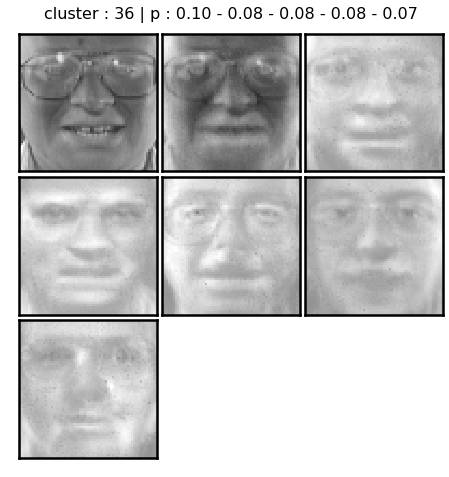

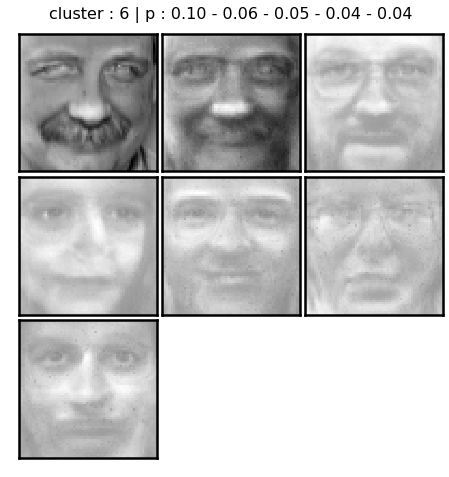

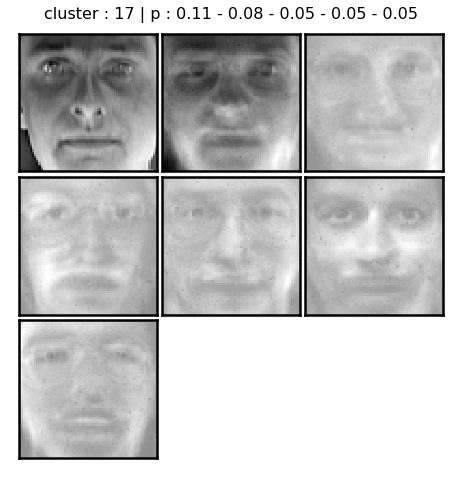

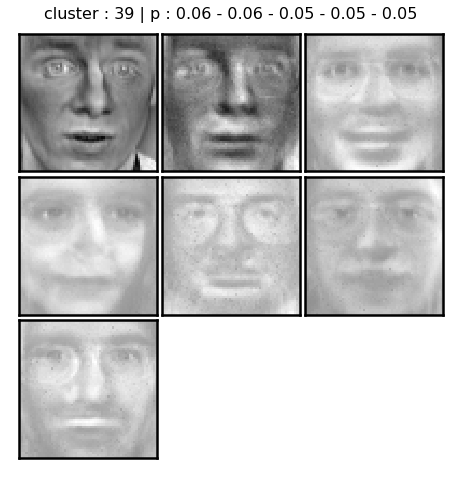

In [9]:
ids = np.random.randint(0, 399, size = 4)
top = 5
for _id in ids:
    top_n = np.argsort(probas[_id])[::-1][:top]

    data = np.stack((faces_centered[_id], reconstruction[_id] - 1, *[Wt[idx] for idx in top_n]))
    
    plot_gallery(images = data, title=f'cluster : {labels[_id]} | p : ' + ' - '.join(['%.2f'%probas[_id, i] for i in top_n]), image_shape = image_shape)


### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with *scikit-learn's* NMF. Print the most common words of each topic. 

Discuss.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF

from scipy.sparse import csr_matrix

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(r):
        topic = D[:, topic_idx]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]


# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)

tfidf_array = csr_matrix.toarray(tfidf)

# Fit the NMF model, print top words
nmf = NMF(n_components=n_components)
nmf.fit_transform(tfidf_array)

vocab = tfidf_vectorizer.vocabulary_
vocab_inv = {v : k for k,v in vocab.items()}
tfidf_feature_names = ['' for _ in range(n_features)]

for k, v in vocab.items():
    tfidf_feature_names[v] = k

print_top_words(nmf.components_.T, tfidf_feature_names, n_top_words)


C:\Users\Tariq\AppData\Roaming\Python\Python37\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


Topic #0: just people don think like know say did make really time way ve right sure good going want got wrong
Topic #1: windows use using window dos program application os drivers software help screen running ms code motif pc work ve mode
Topic #2: god jesus bible faith does christian christians christ believe life heaven sin lord church religion true mary human belief love
Topic #3: thanks know does mail advance hi info interested anybody email like looking help appreciated card information list send need post
Topic #4: car new 00 bike 10 price space cars power sale good year engine years used cost miles condition great 000
Topic #5: edu soon com send university internet ftp mail mit information article cc pub address hope program email mac blood contact
Topic #6: file problem files format ftp win space sound read pub available program site help version image book copy save memory
Topic #7: game team year games win play season players nhl runs toronto ll flyers division goal hockey p

In [11]:
new_data_sample = dataset.data[2036]  # unseen
print(new_data_sample)


Didn't Paul write that if the Resurrection is not true, we are the
biggest fools of all?  However, whether you believe in Christ or not,
His teachings (e.g. love your brotherman as yourself), even if only 
followed at a secular level, could do a great deal to alleviate some of 
the problems we see today in the world.  Even when I was a rabid atheist 
I couldn't deny that.


With which topics does the nmf model best associate this new sample? Does it make sense? What about another new sample?

In [12]:
new_tfidf = tfidf_vectorizer.transform([new_data_sample])

new_tfidf_array = csr_matrix.toarray(new_tfidf)

# Fit the NMF model, print top words

out = nmf.transform(new_tfidf_array)

rec = np.matmul(out, nmf.components_)
ids = np.argsort(rec[0, :])[::-1][:n_top_words]

top_words = ''
for i in range(n_top_words):
    top_words += vocab_inv[ids[i]]
    top_words += ' - '

print(top_words)
    

god - people - just - think - don - jesus - game - bible - like - good - does - believe - time - say - faith - christian - way - life - drive - christians - 


How does this NMF method compare to other embedding methods you know in NLP?

The  nmf method seems to capture the general theme of the text, which touches on religion.

However the main idea (which is about the relevance of christ's teachings) is completely lost in the summary.

The result obtained is on the same level as regular NLP methods (BoW etc), but not comparable to more recent methods that are based on artificial intelligence.